# SNP/Phenotype detection from raw text

In [1]:
%load_ext autoreload
%autoreload 2

import sys

In [2]:
# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')

# set up paths
abstract_dir = '../data/db/papers'

## Assemble a corpus

We will look at abstracts for now

In [3]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLDocParser

xml_parser = UnicodeXMLDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//abstract/p//text() | .//front//article-title//text()',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

Warning: there are unicode chars that cause trouble, e.g.:

In [4]:
import unicodedata
print u'\u2212 8'
txt=u'\xd7'
print unicodedata.normalize('NFKD', txt).encode('ascii','ignore')
print unicode(txt)

− 8

×


Get the actual docs:

In [5]:
import lxml.etree as et
with open('../data/db/papers/19305408.xml') as f:
    for i,doc in enumerate(et.parse(f).xpath('./*')):
        print doc
#         print doc.xpath('.//abstract/p//text() | .//front//article-title//text()')
        print doc.xpath('.//body/p[1]//text()')

<Element article at 0x10c4ccaf0>
['Sudden cardiac death (SCD) and drug-induced ventricular arrhythmia, a major barrier to drug development, are poorly predicted.', '1', ' Prolongation of electrocardiographic QT interval duration, a measure of myocardial repolarization time, is a risk factor for drug-induced arrhythmias and SCD. Continuous QT interval duration is heritable', '2', ' (h', '2', u' \u22480.35) and has multiple environmental and genetic contributors. Its genetic determinants in populations are poorly characterized.', '3', ' Congenital Long and Short QT Syndromes of ventricular arrhythmias and SCD due to extremes of QT interval duration are often caused by mutations with large effect sizes, commonly in ion channels involved in myocardial repolarization. These mutations are typically private to specific families and individually explain little of the population variation in QT interval duration or SCD risk.', '4', ' The few common variants in candidate genes associated with QT

In [6]:
from snorkel.parser import HTMLParser
from snorkel.parser import SentenceParser
from snorkel.parser import CorpusParser
import cPickle

sent_parser = SentenceParser()
html_parser = HTMLParser(path='../data/db/papers/')

corpus_name = 'gwas-text-corpus.pkl'

try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, sent_parser, max_docs=100)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 1.85 s, sys: 195 ms, total: 2.04 s
Wall time: 17.2 s


Test the results:

In [7]:
doc = corpus.documents[2]
print doc

for doc in corpus.documents:
    if doc.name is None: 
        print doc

Document('17684544', Corpus (GWAS Corpus))


In [8]:
sent = corpus.get_sentences()[0]
print sent

Sentence(Document('17447842', Corpus (GWAS Corpus)), 0, u'Novel Crohn Disease Locus Identified by Genome-Wide Association Maps to a Gene Desert on 5p13.1 and Modulates Expression of  PTGER4 To identify novel susceptibility loci for Crohn disease (CD), we undertook a genome-wide association study with more than 300,000 SNPs characterized in 547 patients and 928 controls.')


## Try extracting rs-ids first

In [9]:
# add new paths
sys.path.append('../src/crawler')
sys.path.append('../src/crawler/db')

# import new libs
from kb import KnowledgeBase
from extractor.util import gold_rsid_stats, gold_rsid_precision

from snorkel.candidates import Ngrams
from snorkel.matchers import DictionaryMatch, RegexMatchSpan, Union
from snorkel.candidates import EntityExtractor

# from snorkel.candidates import Candidates

### Create a gold set

Get a list of all the rs-ids we know.

In [10]:
kb = KnowledgeBase()

In [11]:
rs_ids = kb.get_rsid_candidates()
print rs_ids[0]

rs4950928


Get a gold set:

In [12]:
gold_set = frozenset( [ (doc.name, rs_id) for doc in corpus.documents for rs_id in kb.rsids_by_pmid(int(doc.name)) ] )

In [13]:
gold_set_rsids = [rs_id for doc_id, rs_id in gold_set]

### Extract candidates:

In [14]:
from snorkel.candidates import EntityExtractor
# Define a candidate space
ngrams = Ngrams(n_max=1)

# Define matchers
dict_rsid_matcher = DictionaryMatch(d=rs_ids, longest_match_only=False)
gold_rsid_matcher = DictionaryMatch(d=gold_set_rsids, longest_match_only=False)
regx_rsid_matcher = RegexMatchSpan(rgx=r'rs\d+')
rsid_matcher = Union(dict_rsid_matcher, regx_rsid_matcher)

rsid_extractor = EntityExtractor(ngrams, rsid_matcher)
%time rsid_c = rsid_extractor.extract(corpus.get_sentences(), name='all')
for cand in rsid_c[:10]: 
    print cand
print "%s candidates extracted" % len(rsid_c)

# # collect candidates
# %time gold_dict_c = Candidates(ngrams, gold_rsid_matcher, corpus.get_contexts())
# %time rsid_c = Candidates(ngrams, rsid_matcher, corpus.get_contexts())

CPU times: user 717 ms, sys: 56.4 ms, total: 773 ms
Wall time: 739 ms
Span("rs9930506", context=None, chars=[23,31], words=[5,5])
Span("rs6602024", context=None, chars=[22,30], words=[5,5])
Span("rs9930506", context=None, chars=[121,129], words=[23,23])
Span("rs6602024", context=None, chars=[41,49], words=[6,6])
Span("rs1793004", context=None, chars=[17,25], words=[4,4])
Span("rs1992660", context=None, chars=[169,177], words=[35,35])
Span("rs6855911", context=None, chars=[4,12], words=[1,1])
Span("rs6855911", context=None, chars=[46,54], words=[7,7])
Span("rs7341475", context=None, chars=[44,52], words=[6,6])
Span("rs7341475", context=None, chars=[11,19], words=[2,2])
125 candidates extracted


### Statistics

Statistics on all the rsid candidates:

In [15]:
gold_rsid_stats(rsid_c, gold_set)

# of gold annotations	= 830
# of candidates		= 105
Candidate recall	= 0.093
Candidate precision	= 0.733


Statistics on the candidates extracted via dictionary matching.

Recall is how many SNPs in the gold set are actually mentioned in the abstract/txt.
Precision is how many recovered SNPs are also found in the gold set.

The gold set are (pmid, rsid) tuples, so in some cases, there are papers where there is a mention of an rsid from another paper, but this new mention is not recorded in the gold set.

In [16]:
# gold_rsid_stats(gold_dict_c.get_candidates(), gold_set)

Some debugging on the largest rsID candate set:

In [17]:
strange_ngrams = gold_rsid_precision(rsid_c, gold_set)
gold_dict = dict(gold_set)
for ngram in strange_ngrams[:5]:
    print ngram
    # print corpus.get_doc(ngram.doc_id)
    print ngram.context.text

Span("rs6602024", context=None, chars=[22,30], words=[5,5])
Within the PFKP gene, rs6602024 showed very strong association with BMI ( p =  4.9 × 10 − 6 ).
Span("rs6602024", context=None, chars=[41,49], words=[6,6])
We did not replicate association between rs6602024 and obesity-related traits in the GenNet sample, although we found that in European Americans, Hispanic Americans, and African Americans, homozygotes for the rare “A” allele were, on average, 1.0–3.0 BMI units heavier than homozygotes for the more common “G” allele.
Span("rs11209026", context=None, chars=[151,160], words=[25,25])
We replicated the previously reported association with interleukin 23 receptor and interleukin 12B (IL12B) polymorphisms in PS and PSA cohorts (IL23R: rs11209026, U.S. PS, P = 1.4×10 −4 ; U.K. PSA: P = 8.0×10 −4 ; IL12B:rs6887695, U.S. PS, P = 5×10 −5  and U.K. PSA, P = 1.3×10 −3 ) and detected an independent association in the IL23R region with a SNP 4 kb upstream from IL12RB2 (P = 0.001).
Span("rs

## Get candidate p-values

Need to use regular expressions for this.

In [18]:
from snorkel.matchers import RegexMatchSpan

Test out the regexp.

In [19]:
from extractor.matcher import PvalMatcher
rgx1 = u'[1-9]\d?[\xb7\.]?\d*\s*[\xd7\*]\s*10\s*[-\u2212\u2013]\s*\d+'
pval_rgx_matcher1 = RegexMatchSpan(rgx=rgx1)
rgx2 = u'[1-9]\d?[\xb7\.]?\d*\s*[eE][-\u2212\u2013]\d+'
pval_rgx_matcher2 = RegexMatchSpan(rgx=rgx2)
rgx3 = u'0\.0000+\d+'
pval_rgx_matcher3 = RegexMatchSpan(rgx=rgx3)
pval_matcher = Union(pval_rgx_matcher1, pval_rgx_matcher2, pval_rgx_matcher3)
# pval_matcher = PvalMatcher()
ngrams = Ngrams(n_max=7)
pval_extractor = EntityExtractor(ngrams, pval_matcher)

%time pval_c = pval_extractor.extract(corpus.get_sentences(), name='all')

CPU times: user 4.06 s, sys: 40.1 ms, total: 4.1 s
Wall time: 4.12 s


In [20]:
print 'Got %d candidates, e.g.:' % len(pval_c)
for candidate in pval_c[:5]:
    print unicode(candidate)

Got 209 candidates, e.g.:
Span("4 × 10 −4", context=None, chars=[43,51], words=[7,11])
Span("8.6 ×10 − 7", context=None, chars=[82,92], words=[15,19])
Span("3.4 × 10 − 8", context=None, chars=[122,133], words=[27,31])
Span("9.1 × 10 − 7", context=None, chars=[156,167], words=[39,43])
Span("4.9 × 10 − 6", context=None, chars=[79,90], words=[15,19])


### Statistics

First, how many p-values that should be present do we extract?

In [21]:
# we need to define a p-value -> float converter
from extractor.util import pvalue_to_float, gold_pval_stats, gold_pval_precision

print pvalue_to_float(u"6.2×10 −5")
print pvalue_to_float(u"1.85×10 −20")

6.2e-05
1.85e-20


In [22]:
from kb import KnowledgeBase
kb = KnowledgeBase()
gold_set_pvals = frozenset([ (doc.name, pval) for doc in corpus.documents for pval in kb.pvals_by_pmid(int(doc.name)) ])


In [23]:
print 'Found %d gold mentions, e.g.:' % len(gold_set_pvals)
print list(gold_set_pvals)[:5]
print

print gold_pval_stats(pval_c, gold_set_pvals)

Found 674 gold mentions, e.g.:
[('19668339', 7e-06), ('17903294', 1e-06), ('19305408', 5.0000000000000005e-22), ('17903292', 8e-06), ('18464913', 3e-06)]

# of gold annotations	= 388
# of candidates		= 161
Candidate recall	= 0.240
Candidate precision	= 0.578
None


Some debugging...

In [24]:
gold_pval_dict = { doc_id : [] for doc_id, pval in gold_set_pvals }
for doc_id, pval in gold_set_pvals:
    gold_pval_dict[doc_id].append(pval)
    
strange_ngrams = gold_pval_precision(pval_c, gold_set_pvals)
for ngram in strange_ngrams[:5]:
    print unicode(ngram)
    print ngram.context.text
    print gold_pval_dict[ngram.context.document.name]
    print

Span("4 × 10 −4", context=None, chars=[43,51], words=[7,11])
Significant evidence of association ( p  < 4 × 10 −4 ) was found in case/control comparisons with the replication data, while associated alleles were over-transmitted to affected offspring ( p  < 0.05), thus confirming that the 5p13.1 locus contributes to CD susceptibility.
[1e-06, 2e-18, 2e-12]

Span("4.9 × 10 − 6", context=None, chars=[79,90], words=[15,19])
Within the PFKP gene, rs6602024 showed very strong association with BMI ( p =  4.9 × 10 − 6 ).
[9e-07, 3.0000000000000004e-08]

Span("6.05 × 10 −11", context=None, chars=[120,132], words=[29,33])
SNP rs6855911 showed the strongest association ( p  = 1.84 × 10 −16 ), along with eight others ( p  = 7.75 × 10 −16  to 6.05 × 10 −11 ).
[2e-16]

Span("2.9 × 10 −5", context=None, chars=[115,125], words=[24,28])
We found a female-specific association with rs7341475, a SNP in the fourth intron of the reelin (RELN) gene ( p  = 2.9 × 10 −5  in women), with a significant gene-sex e

Potential analysis question: how many rsIDs that we extracted earlier also have an associated p-value?

We will say that if an rsID and a p-value occur in the same document, they have been identified correctly.

So we extract from our gold set tuples of the form (pmid, rsID, p-value). We compare them to candidate tuples, where an rsID and a p-value are associated if they occur in the same sentence.

This seems like something to be checked at the relation extraction stage.

## Extract phenotypes

In [52]:
from extractor.util import change_name
# Define a candidate space
ngrams = Ngrams(n_max=4)

# collect phenotype list
from db.kb import KnowledgeBase
kb = KnowledgeBase()
# phenotype_list = kb.get_phenotype_candidates(mod_fn=change_name)
# TODO: load disease names from NCBI

# Define matchers
from snorkel.matchers import DictionaryMatch
from extractor.matcher import PhenotypeMatcher
# phen_matcher = DictionaryMatch(d=phenotype_list, longest_match_only=True, ignore_case=True, stemmer='porter')
phen_matcher = PhenotypeMatcher(d=phenotype_list, ignore_case=True, mod_fn=change_name)

# Extractor
ngrams = Ngrams(n_max=7)
phen_extractor = EntityExtractor(ngrams, phen_matcher)

# collect candidates
%time phen_c = phen_extractor.extract(corpus.get_sentences(), name='all')

CPU times: user 15.8 s, sys: 97.7 ms, total: 15.9 s
Wall time: 15.9 s


In [53]:
# remove tested candidates

# load existing candidates into a dict
span_dict = { str(span.context) : list() for span in phen_c }
for span in pval_c:
    span_dict[str(span.context)].append( (span.char_start, span.char_end) )

def nested(ivl1, ivl2):
    if ivl1 != ivl2 and ivl2[0] <= ivl1[0] <= ivl1[1] <= ivl2[1]:
        return True
    else:
        return False

new_phen_c = list()
for span in phen_c:
    span_ivl = span.char_start, span.char_end
    span_name = str(span.context)
    if all([not nested(span_ivl, other_ivl) for other_ivl in span_dict[span_name]]):
        new_phen_c.append(span)

print len(new_phen_c), len(phen_c)
phen_c = new_phen_c

10765 10766


In [54]:
print 'Got %d candidates, e.g.:' % len(phen_c)
for candidate in phen_c[:5]:
    print candidate

Got 10765 candidates, e.g.:
Span("(CD),", context=None, chars=[188,192], words=[29,32])
Span("CD),", context=None, chars=[189,192], words=[30,32])
Span("Crohn Disease", context=None, chars=[6,18], words=[1,2])
Span("Crohn disease", context=None, chars=[174,186], words=[27,28])
Span("(CD", context=None, chars=[188,190], words=[29,30])


### Statistics

In [55]:
from db.kb import KnowledgeBase
from nltk.stem import PorterStemmer
from extractor.util import change_name

kb = KnowledgeBase() # reload
gold_set_phens = frozenset ([ 
    (doc.name, phen.ontology_ref) for doc in corpus.documents 
                                  for phen in kb.phen_by_pmid(int(doc.name))
])

# map phenotype names to their id
stemmer = PorterStemmer()
phen2id = {
    change_name(syn) : phen.ontology_ref for doc in corpus.documents
                                                  for phen in kb.phen_by_pmid(doc.name)
                                                  for syn in [phen.name] + phen.synonyms.split('|')
}
id2phen = {
    phen.ontology_ref : phen for doc in corpus.documents
                             for phen in kb.phen_by_pmid(doc.name)
}

print 'Found %d gold mentions, e.g.:' % len(gold_set_phens)
print list(gold_set_phens)[:5]
print len(phen2id), len(id2phen)

Found 322 gold mentions, e.g.:
[('17658951', u'http://www.ebi.ac.uk/efo/EFO_0004764'), ('17903294', u'http://purl.obolibrary.org/obo/GO_0070527'), ('20038947', u'http://www.ebi.ac.uk/efo/EFO_0003761'), ('19197348', u'http://www.ebi.ac.uk/efo/EFO_0004748'), ('17658951', u'http://www.ebi.ac.uk/efo/EFO_0004626')]
833 216


In [56]:
gt_dict_pos = dict()
gt_dict_neg = dict()
for span in phen_c:
    phen_id = phen2id.get(span.get_span(), None)
    if (span.context.document.name, phen_id) in gold_set_phens:
        gt_dict_pos[span.uid] = +1
    else:
        gt_dict_neg[span.uid] = -1

print len(gt_dict_pos), len(gt_dict_neg)
gt_dict = dict(gt_dict_pos.items() + gt_dict_neg.items())

103 10468


In [57]:
from extractor.util import gold_phen_stats
gold_phen_stats(phen_c, gold_set_phens, phen2id)

# of gold annotations	= 322
# of candidates		= 10765
Candidate recall	= 0.323
Candidate precision	= 0.010


Why do we get low recall?

In [59]:
from extractor.util import gold_phen_recall

gold_dict_phen = { doc_id : set() for doc_id, phen_id in gold_set_phens }
for doc_id, phen_id in gold_set_phens:
    gold_dict_phen[doc_id].add(phen_id)
    
phen_not_found = list(gold_phen_recall(phen_c, gold_set_phens, phen2id))
doc_id, phen_id = phen_not_found[2]
print id2phen[phen_id].name 
print doc2id[doc_id].sentences[0]
for span in ngrams.apply(doc2id[doc_id].sentences[0]):
    print span.get_span()
    if phen_matcher._f(span):    
        phen_name = span.get_span()
        print phen_name
        phen_id = phen2id.get(change_name(phen_name), None)
        print phen_id
        if not phen_id or phen_id not in gold_dict_phen[span.context.document.name]:
            print span.context.document.name, phen_id
            print gold_dict_phen[span.context.document.name]
        print


igfbp-3 measurement
Sentence(Document('17658951', Corpus (GWAS Corpus)), 0, u'Genome-Wide Association Scan Shows Genetic Variants in the  FTO  Gene Are Associated with Obesity-Related Traits The obesity epidemic is responsible for a substantial economic burden in developed countries and is a major risk factor for type 2 diabetes and cardiovascular disease.')


In [60]:
change_name('waist circumference') in phenotype_list

True

In [61]:
from extractor.util import gold_phen_recall
kb = KnowledgeBase()
doc2id = {doc.name : doc for doc in corpus.documents}

phen_not_found = list(gold_phen_recall(phen_c, gold_set_phens, phen2id))
print len(phen_not_found)
for doc_id, phen_id in phen_not_found[:100]:
    if len(gold_dict_phen[doc_id]) > 3: continue
    print doc_id
    for phen_id2 in gold_dict_phen[doc_id]:
        print id2phen[phen_id2].name, phen_id2
#     print gold_dict_phen[doc_id]
    print id2phen[phen_id].name, id2phen[phen_id].ontology_ref
    print id2phen[phen_id].synonyms    
    print kb.title_by_pmid(doc_id)
    print ' '.join(s.text for s in doc2id[doc_id].sentences)
    print

218
19798445
blood metabolite measurement http://www.ebi.ac.uk/efo/EFO_0005664
sphingolipid measurement http://www.ebi.ac.uk/efo/EFO_0004622
blood metabolite measurement http://www.ebi.ac.uk/efo/EFO_0005664

Genetic determinants of circulating sphingolipid concentrations in European populations.
Genetic Determinants of Circulating Sphingolipid Concentrations in European Populations Sphingolipids have essential roles as structural components of cell membranes and in cell signalling, and disruption of their metabolism causes several diseases, with diverse neurological, psychiatric, and metabolic consequences. Increasingly, variants within a few of the genes that encode enzymes involved in sphingolipid metabolism are being associated with complex disease phenotypes. Direct experimental evidence supports a role of specific sphingolipid species in several common complex chronic disease processes including atherosclerotic plaque formation, myocardial infarction (MI), cardiomyopathy, pancreat

In [ ]:
stemmer.stem('alzheimer')

## Now let's do some learning!

### Learning correct phenotypes

Extract features, and store them to a file.

In [31]:
import cPickle        
from snorkel.features import NgramFeaturizer

pkl_f = 'phenotype_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramFeaturizer()
    featurizer.fit_transform(phen_c)

Building feature index...
Extracting features...
0/37210
5000/37210
10000/37210
15000/37210
20000/37210
25000/37210
30000/37210
35000/37210


In [32]:
for f in featurizer.get_features_by_candidate(phen_c[0])[:10]: print f

DDLIB_WORD_SEQ_[disease]
DDLIB_LEMMA_SEQ_[disease]
DDLIB_POS_SEQ_[NN]
DDLIB_DEP_SEQ_[nmod]
DDLIB_W_LEFT_1_[crohn]
DDLIB_W_LEFT_POS_1_[NN]
DDLIB_W_LEFT_2_[for crohn]
DDLIB_W_LEFT_POS_2_[IN NN]
DDLIB_W_LEFT_3_[locus for crohn]
DDLIB_W_LEFT_POS_3_[NNS IN NN]


We now create a gold truth set. Phenotype mentions are said to be correct if the phenotype is known to be mentioned in the document.

In [79]:
# small helper functions:
def get_doc_id(entity):
    return entity.uid.split('-')[0]

def get_phenotype(entity, stem=False):
    phenotype = entity.get_span()
    if stem:
        phenotype = stemmer.stem(phenotype)
    return phenotype.lower()
        
    
print phen_c[0]
print phen_c[0].uid
print get_doc_id(phen_c[0])
print get_phenotype(phen_c[0])

Span("disease", context=None, chars=[48,54], words=[7,7])
17447842-0:48-54
17447842
disease


In [80]:
# load true phenotype mentions
doc_ids = [phen.context.document.name for phen in phen_c]
gold_phen_dict = { doc_id : kb.phens_by_pmid(doc_id) for doc_id in doc_ids}

KeyboardInterrupt: 

In [35]:
# classify candidates as correct or not
uids = list()
gt = list()
for doc_id, phenotype in zip(doc_ids, phen_c):
    uids.append(phenotype.uid)
    phenotype_name = get_phenotype(phenotype)
    if phenotype_name in gold_phen_dict[doc_id]:
        gt.append(+1)
    else:
        gt.append(-1)

In [36]:
import numpy as np

# Split into train and test set
candidates = phen_c
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    if c.uid in gt_dict:
        gold_candidates.append(c)
        gold_labels.append(gt_dict[c.uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if gt_dict.get(c.uid,0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if gt_dict.get(c.uid,0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==-1])

Training set size: 1133
Gold set size: 1133
Positive labels in training set: 39
Negative labels in training set: 1094
Positive labels in gold set: 36
Negative labels in gold set: 1097


#### Labeling functions

In [43]:
# load set of dictionary phenotypes
kb = KnowledgeBase()
phenotype_list = kb.get_phenotype_candidates() # TODO: load disease names from NCBI
# phenotype_list = [stemmer.stem(phenotype) for phenotype in phenotype_list]
phenotype_list = [phenotype for phenotype in phenotype_list]
phenotype_set = set(phenotype_list)

def LF_in_set(m):
    return +1 if get_phenotype(m, stem=True) in phenotype_list else -1
def LF_associated(m):
    return +1 if 'associate' in m.pre_window('lemmas') else 0
def LF_influencing(m):
    return +1 if 'influence' in m.pre_window('lemmas') else 0
def LF_related(m):
    return +1 if 'relate' in m.pre_window('lemmas') else 0
def LF_phenotype(m):
    return +1 if 'phenotype' in m.pre_window('lemmas') or 'phenotype' in m.post_window('lemmas') else 0

# negative LFs
def LF_previously(m):
    return -1 if 'previously' in m.pre_window('lemmas', 8) else 0
def LF_obese(m):
    words = m.get_span().split(' ')        
    return -1 if 'obese' in words and len(words) == 1 else 0
def LF_further(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')    
    return -1 if 'further' in lemmas or 'furthermore' in lemmas else 0
def LF_also(m):
    words = m.get_span().split(' ')        
    return -1 if 'also' in words else 0
def LF_age(m):
    words = m.get_span().split(' ')
    return -1 if 'age' in words or 'aging' in words or 'ages' in words else 0
def LF_trait(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')
    return -1 if 'trait' in lemmas else 0
def LF_weight(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')
    return -1 if 'weight' in lemmas else 0
def LF_recently(m):
    words = m.get_span().split(' ')    
    return -1 if 'recently' in words else 0
def LF_addit(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')
    return -1 if 'addit' in lemmas else 0
def LF_may(m):
    words = m.get_span().split(' ')
    return -1 if 'may' in words else 0
def LF_short(m):
    lemmas = m.get_attrib_span('lemmas').split(' ')    
    return -1 if len(lemmas) == 1 else 0

In [44]:
LFs = [LF_associated, LF_influencing, LF_related, LF_previously, LF_phenotype, LF_obese, LF_further,
       LF_also, LF_age, LF_trait, LF_weight, LF_recently, LF_addit, LF_may, LF_short]

In [45]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LFs, featurizer=NgramFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/20128
5000/20128
10000/20128
15000/20128
20000/20128
LF Summary Statistics: 15 LFs applied to 1133 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		77.85%
Overlap (candidates w/ > 1 labels):		13.77%
Conflict (candidates w/ conflicting labels):	12.71%


In [62]:
# a bit of debugging
for i in range(80, 120):
    if gt[i] == -1:
        print phen_c[i].get_span()
        print phen_c[i]
        print gt[i]
        print gold_phen_dict[doc_ids[i]]
    #     print phenotypes[i].pre_window('lemmas')
        for LF in LFs:
            print LF(phen_c[i]),
        print '\n'

population
Span("population", context=None, chars=[163,172], words=[26,26])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 

controls
Span("controls", context=None, chars=[217,224], words=[36,36])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 

replication
Span("replication", context=None, chars=[28,38], words=[4,4])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 

ulcerative colitis
Span("ulcerative colitis", context=None, chars=[39,56], words=[6,7])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

ulcerative
Span("ulcerative", context=None, chars=[39,48], words=[6,6])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 

colitis
Span("colitis", context=None, chars=[50,56], words=[7,7])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 

replicated
Span("replicated", context=None, chars=[34,43], words=[7,7])
-1
set([u"crohn's disease"])
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 

controls
Span("controls", context=None, chars=[

#### Results

In [63]:
lf_stats = training_set.lf_stats()
lf_stats[:5]

,conflicts,coverage,j,overlaps
LF_associated,0.085613,0.100618,0,0.085613
LF_influencing,0.030009,0.039718,1,0.030009
LF_related,0.000883,0.001765,2,0.000883
LF_previously,0.002648,0.011474,3,0.009709
LF_phenotype,0.015887,0.017652,4,0.015887


In [64]:
lf_stats.hist("coverage")

array([[<matplotlib.axes.AxesSubplot object at 0x11a04ccd0>]], dtype=object)

In [65]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

learner = Learner(training_set, model=snorkel.learning.LogReg())

In [66]:
# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

In [57]:
from snorkel.learning_utils import GridSearch

gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.028215
	Learning epoch = 250	Gradient mag. = 0.031598
	Learning epoch = 500	Gradient mag. = 0.034183
	Learning epoch = 750	Gradient mag. = 0.037504
Final gradient magnitude for rate=0.01, mu=1e-05: 0.042
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.052613
	Learning epoch = 250	Gradient mag. = 0.057508
	Learning epoch = 500	Gradient mag. = 0.060609
	Learning epoch = 750	Gradient mag. = 0.064753
Final gradient magnitude for rate=0.01, mu=1e-05: 0.070
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.028215
	Learning epoch = 250	Gradient mag. = 0.031612
	Learning epoch = 500	Gradient mag. = 0.034215
	Learning epoch = 750	Gradient mag. = 0.037557
Final gradient magnitude for rate=0.01, mu=1e-07: 0.042
Testin

In [58]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.166667,0.1,0.125
1,0.00001,2,0.166667,0.1,0.125
2,0.00000,1,0.166667,0.1,0.125
3,0.00000,2,0.166667,0.1,0.125


In [59]:
learner.test(test_candidates, test_labels)

Applying LFs...
Featurizing...
Test set size:	566
----------------------------------------
Precision:	0.217391304348
Recall:		0.3125
F1 Score:	0.25641025641
----------------------------------------
TP: 5 | FP: 18 | TN: 532 | FN: 11


/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Let's extract some relations!

In [68]:
from snorkel.candidates import RelationExtractor, EntityExtractor

ngrams = Ngrams(n_max=5)
rsid_extractor = EntityExtractor(ngrams, rsid_matcher)
pval_extractor = EntityExtractor(ngrams, pval_matcher)
rel_extractor = RelationExtractor(rsid_extractor, pval_extractor)

%time pval_relations = rel_extractor.extract(corpus.get_sentences(), name='all')

CPU times: user 3.44 s, sys: 367 ms, total: 3.81 s
Wall time: 4.26 s


Again, extract features.

In [75]:
import cPickle        
from snorkel.features import NgramPairFeaturizer

pkl_f = 'pval_rel_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramPairFeaturizer()
    featurizer.fit_transform(pval_relations)

Building feature index...
Extracting features...
0/3353


Now we create the gold truth set.

In [82]:
# load true phenotype mentions
from math import floor, log10
from db.kb import KnowledgeBase
kb = KnowledgeBase()

doc_ids = [get_doc_id(rel) for rel in pval_relations]
# we only get the magnitude of the p-value:
gold_pval_dict = { 
    doc_id : set([ 
                (assoc.snp.rs_id, floor(log10(assoc.pvalue))) for assoc in kb.assoc_by_pmid(doc_id) if assoc and assoc.pvalue 
            ])
    for doc_id in doc_ids
}

In [84]:
# small helper functions:
from extractor.util import pvalue_to_float
def get_rsid_pval(rel, stem=False):
    # pvalue
    pval_txt = rel.span1.get_span()
    pval = pvalue_to_float(pval_txt)
    # rsid
    rsid = rel.span0.get_span()    
    return rsid, pval
    
# print pval_relations[0].mention2()
print get_rsid_pval(pval_relations[0])

(u'rs9930506', 8.599999999999999e-07)


In [85]:
# classify candidates as correct or not
from math import floor, log10
uids = list()
gt = list()

for doc_id, rel in zip(doc_ids, pval_relations):
    rsid, pval = get_rsid_pval(rel)
    
    # we say that its correct if we get the right order of magnitude
    if pval:
        uids.append(rel.uid)
        pval_mag = floor(log10(pval))
        if (rsid, pval_mag) in gold_pval_dict[doc_id]:
            gt.append(+1)
        else:
            gt.append(-1)

#### Labeling functions

In [ ]:
#### WHAT IS BELOW IS CURRENTLY NOT WORKING

Print a few examples, for debugging.

In [88]:
for i in range(1000):
    r = pval_relations[i]
    pos_labels = [LF(r) for LF in pos_LFs]
    neg_labels = [LF(r) for LF in neg_LFs]
    labels = pos_labels + neg_labels
#     if 1 not in labels and -1 not in labels:
    if 1 in labels and -1 in labels:        
        print '----'
        print r.span0.context.text
        print r.span0
        print r.span1
        print
        print pos_labels
        print neg_labels
        print internal_words(r, lemmas=True)
    #     print r.pre_window1('words')
    #     print r.post_window2('words')    
        print

AttributeError: 'SpanPair' object has no attribute 'e1_idxs'

Now, define a few labeling functions

In [87]:
import re
def internal_words(r, lemmas=False):
    # last index of first mention, first index of second mention:
    first_idx1 = min(r.span0.get_word_start())
    first_idx2 = min(r.span1.get_word_start())
    if first_idx1 < first_idx2:
        idx1 = max(r.)
        idx2 = min(r.e2_idxs)
    else:
        idx1 = max(r.e2_idxs)
        idx2 = min(r.e1_idxs)
    # internal words
    if lemmas:
        return r.lemmas[idx1+1:idx2]
    else:
        return r.words[idx1+1:idx2]
        

def internal_range(r):
    # last index of first mention, first index of second mention:
    idx1 = min(r.mention1.idxs + r.mention2.idxs)
    idx2 = max(r.mention1.idxs + r.mention2.idxs)
    # internal words
    return idx1, idx2

# positive LFs
def LF_one_lrb(m):
    iw = internal_words(m)
    return +1 if '-LRB-' in iw and '-RRB-' not in iw else 0
def LF_in_pars(m):
    iw = internal_words(m)
    iwj = ' '.join([w.lower() for w in iw])
    n_rs = len(re.findall('rs\d+', iwj))
    return +1 \
        if '-LRB-' not in iw and '-RRB-' not in iw \
        and '-LRB-' in m.pre_window1('words', 5) \
        and '-RRB-' in m.post_window2('words', 5) \
        and n_rs == 0 \
        else 0
def LF_associate(m):
    iw = internal_words(m, lemmas=True)
    return +1 if 'associate' in iw and len(iw) <= 7 else 0
def LF_for(m):
    iw = internal_words(m, lemmas=True)
    return +1 if 'for' in iw and len(iw) <= 5 else 0
def LF_col(m):
    iw = internal_words(m, lemmas=True)
    return +1 if ':' in iw and len(iw) <= 5 else 0
def LF_two_p(m):
    iw = internal_words(m)
    iwj = ' '.join([w.lower() for w in iw])
    n_p = len(re.findall('p =', iwj))
    n_rs = len(re.findall('rs\d+', iwj))
    return 1 if n_p >= 2 and n_rs == 0 else 0

# negative LFs
def LF_rrb(m):
    iw = internal_words(m)
    return -1 if '-RRB-' in iw else 0
def LF_no_p(m):
    iw = internal_words(m)
    return -1 if 'p' not in [w.lower() for w in m.pre_window2('words', 5)] \
              and 'for' not in [w.lower() for w in m.pre_window1('words')] \
              and len(iw) >= 3 \
              else 0
# def LF_mid_p(m):
#     iw = internal_words(m)
#     return -1 if 'p' in [w.lower() for w in iw] else 0
def LF_semicol(m):
    iw = internal_words(m)
    return -1 if ';' in iw and '-LRB-' not in iw and len(iw) >= 5 else 0
def LF_and(m):
    iw = internal_words(m)
    return -1 if 'and' in iw else 0

pos_LFs = [LF_one_lrb, LF_in_pars, LF_associate, LF_for, LF_col, LF_two_p]
neg_LFs = [LF_rrb, LF_no_p, LF_semicol, LF_and]
LFs = pos_LFs + neg_LFs

In [426]:
DDL.update_gt(gt, uids=uids)
n_data = DDL.num_candidates()
idxs = np.arange(start=n_data/2, stop=n_data)
DDL.set_holdout(idxs)

DDL.apply_lfs(LFs, clear=True)

LF stats on training set
Coverage:	96.051%
Overlap:	45.877%
Conflict:	4.878%


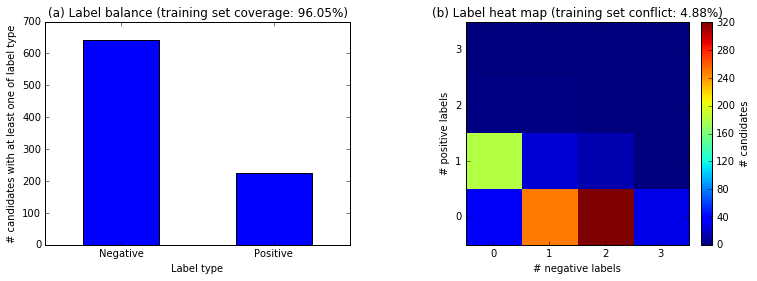

In [427]:
DDL.print_lf_stats()
DDL.plot_lf_stats()


Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.316057
	Learning epoch = 250	Gradient mag. = 0.481987
Final gradient magnitude for rate=0.01, mu=1e-07: 0.597
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.055793
	Learning epoch = 250	Gradient mag. = 0.058497
	Learning epoch = 500	Gradient mag. = 0.058266
	Learning epoch = 750	Gradient mag. = 0.058038
	Learning epoch = 1000	Gradient mag. = 0.057811
	Learning epoch = 1250	Gradient mag. = 0.057587
	Learning epoch = 1500	Gradient mag. = 0.057364
	Learning epoch = 1750	Gradient mag. = 0.057144
	Learning epoch = 2000	Gradient mag. = 0.056925
	Learning epoch = 2250	Gradient mag. = 0.056708
	Learning epoch = 2500	Gradient mag. = 0.056493
	Learning epoch = 2750	Gradient mag. = 0.056280
Final gradient magnitude for rate=0.01, mu=1e-09: 0.056
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.055793
	Learning epoch = 250	Gradient mag. = 0

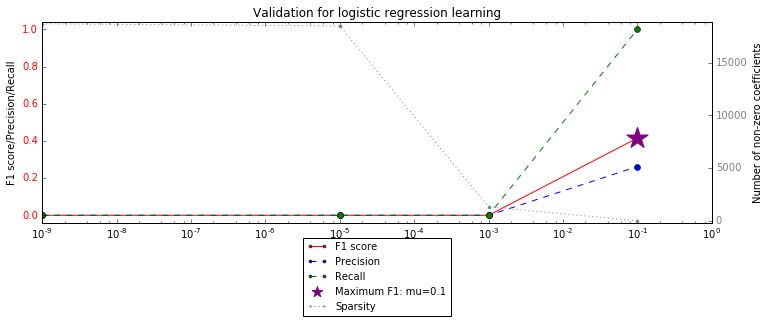

CPU times: user 29.1 s, sys: 417 ms, total: 29.5 s
Wall time: 29.8 s


<snorkel.snorkel.ModelLog instance at 0x14586fcb0>

In [428]:
import matplotlib
import numpy as np
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)